## Libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.colors as plc 
import xclim.indices as xc
from xclim.indices import warm_and_dry_days
from xclim.indices import warm_and_wet_days
from xclim.core.calendar import percentile_doy
#import pymannkendall as mk
import geopandas as gpd

In [3]:
from xclim.core.units import (
    convert_units_to,
    declare_units,
    ensure_delta,
    pint2cfunits,
    rate2amount,
    str2pint,
    to_agg_units,
)
from xclim.core.calendar import resample_doy

## Colorbar

In [4]:
import sys
sys.path.insert(0,'/work/remhi/gg21021/Zapata_colormaps/zapata')
import colormap as zcol
ss = zcol.make_cmap('3w_bgYr', colpath ='/work/remhi/gg21021/Zapata_colormaps/zapata/SciVis_colormaps')

Using colormap /work/remhi/gg21021/Zapata_colormaps/zapata/SciVis_colormaps/3w_bgYr.xml


## SUMMER DAYS

## Number of days with daily maximum temperature greater than 25°C. 

In [7]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc') 
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"

In [8]:
##Evaluation
#Evaluation of the indicator through the xclim library
Su=xc.tx_days_above(tasmax, thresh='25 degC', freq='YS')
Su_mean=Su.mean(dim='time')
Su_mean=Su_mean.to_dataset(name='Su')
Su=Su_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/su_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [118]:
#CSV
Su_mean=Su.mean(dim= ['rlat','rlon']) 
Su_std=Su.std(dim= ['rlat','rlon'])
df=Su_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMAX_2M':'Su[days]'})
df_std=Su_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMAX_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Su[days]'] = np.round(df['Su[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/su_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [51]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Su_mean= Su.mean(dim='time')
clip_var = msk_me * Su_mean
ds=clip_var.to_dataset(name='Su[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Su[d]'] = np.round(df['Su[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/summer_days/su_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

Text(0.5, 1.0, 'Summer days')

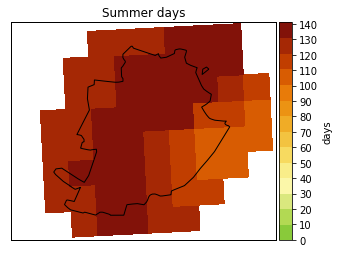

In [9]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/su_era5-2km-italy_year_comune_torino_1991-2020.nc')

Su =  np.round((ds['Su']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Su),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+3,10),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+3, 10),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Su
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+3)
cbar.set_label('days')
plt.title('Summer days')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/su_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Tropical Nights

##  Number of days with daily minimum temperature greater than 20°C.

In [121]:
##DATA
#Loading data: Min. Temperature
data_temp= xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMIN_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tn=data_temp['TMIN_2M']
tn.attrs["units"] = "K"

In [122]:
##Evaluation
#Evaluationof the indicator through the xclim library
Tr= xc.tn_days_above(tn, thresh='20.0 degC', freq='YS')
Tr_mean=Tr.mean(dim='time')
Tr_mean=Tr_mean.to_dataset(name='Tr')
Tr=Tr_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/tr_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [123]:
#CSV
Tr_mean=Tr.mean(dim= ['rlat','rlon'])
Tr_std=Tr.std(dim= ['rlat','rlon'])
df=Tr_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMIN_2M':'Tr[days]'})
df_std=Tr_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMIN_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tr[days]'] = np.round(df['Tr[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/tr_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [54]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Tr_mean= Tr.mean(dim='time')
clip_var = msk_me * Tr_mean
ds=clip_var.to_dataset(name='Tr[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Tr[d]'] = np.round(df['Tr[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/tropical_night/tr_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

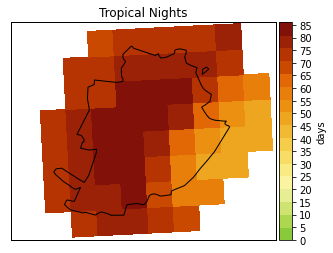

In [21]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/tr_era5-2km-italy_year_comune_torino_1991-2020.nc')

Tr = np.round((ds['Tr']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Tr),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,5),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 5),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Tr
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Tropical Nights')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/tr_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Hot Waves

## Number of days with daily maximum temperature greater than 35°C.

In [12]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"

In [13]:
##Evaluation
#Evaluationof the indicator through the xclim library
Hw=xc.tx_days_above(tasmax, thresh='35 degC', freq='YS')
Hw_mean=Hw.mean(dim='time')
Hw_mean=Hw_mean.to_dataset(name='Hw')
Hw=Hw_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/hw_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [128]:
#CSV
Hw_mean=Hw.mean(dim= ['rlat','rlon']) 
Hw_std=Hw.std(dim= ['rlat','rlon'])
df=Hw_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMAX_2M':'Hw[days]'})
df_std=Hw_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMAX_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Hw[days]'] = np.round(df['Hw[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/hw_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [57]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Hw_mean= Hw.mean(dim='time')
clip_var = msk_me * Hw_mean
ds=clip_var.to_dataset(name='Hw[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Hw[d]'] = np.round(df['Hw[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/hot_waves/hw_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/work/remhi/ap21322/miniconda3/envs/ale/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


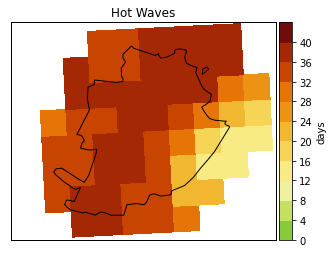

In [22]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/hw_era5-2km-italy_year_comune_torino_1991-2020.nc')

Hw = np.round((ds['Hw']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Hw),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,4),0)
ticks_label = np.round(np.arange(vmin, vmax+1,4),0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Hw
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks, label= ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Hot Waves')
#plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/hw_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Humidex5

## It is a measure of perceived heat that results from the combined effect of humidity and temperature. Category 5: number of days per year in which the humidex index is greater than 45°C. 

In [58]:
##DATA
#Loading data: Temperature, humidity and pressure 
data_umidità_s = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/QV_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
q=data_umidità_s['QV_2M']
q = q.load()
data_temp=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M']
t = t.load()
data_press=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/PMSL_1991_2020_VHR-REA_IT_comune_torino.nc')
p=data_press['PMSL']
p = p.load()

In [59]:
#Components for the evaluation of the index
T0 = 273.15
w = q #the mixing ratio can be approximated with the specific humidity

es = 611.0 * np.exp((17.67*(t - T0)) / (t - 29.65))

w_s =0.622*(es / p)
rh = np.round((w / w_s) * 100)

rh = xr.where(rh > 100, 100, rh)
rh.attrs["units"] = "%"
rh = rh.load()

In [60]:
#Loading data: Max. temperature
data_tempmax=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_tempmax['TMAX_2M']
tasmax = tasmax.load()
tasmax_deg=tasmax-273.15
tasmax_deg = tasmax_deg.load()

In [61]:
#Evaluation
exphum=6.11*10**(7.5*tasmax_deg/(237.7+tasmax_deg))*rh.values/100;
humidex=tasmax_deg+0.5555*(exphum-10);
classe_media1=xr.where(humidex >=45,1,0)   #Category 5-number of days per year in which the humidex index is greater than 45°C.
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='Humidex5')
Humidex5=classe_media3.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [117]:
#CSV
ds=classe_media2.to_dataset(name='Humidex5[days]')
Humidex_mean=ds.mean(dim= ['rlat','rlon'])
Humidex_std=ds.std(dim= ['rlat','rlon'])
df=Humidex_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m'])
df_std=Humidex_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'Humidex5[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Humidex5[days]'] = np.round(df['Humidex5[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [62]:
#Shapefile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Humidex5_mean=classe_media2.mean(dim='time')
clip_var = msk_me * Humidex5_mean
ds=clip_var.to_dataset(name='Humidex5[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)   
df['Humidex5[d]'] = np.round(df['Humidex5[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/humidex/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

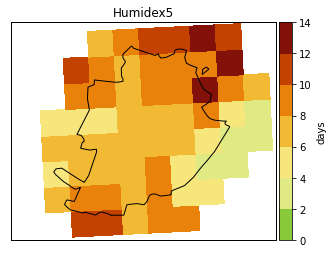

In [32]:
#Map 
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/Humidex5.nc')

Humidex5 = classe_media3 
lon = classe_media3.lon.values 
lat = classe_media3.lat.values 


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Humidex5
vmax = round(np.nanmax(clip_var),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,2),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 2),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))

cmap = plc.ListedColormap(colors)

mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1) 


c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
# cbar.set_ticks(ticks)  # Definisci i ticks
# cbar.set_ticklabels(ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Humidex5')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## WSDI

## Total number of days per period in which the daily maximum temperature is greater than the 90th percentile of the daily maximum temperature in intervals of at least 6 consecutive days.


In [63]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"
tasmax_per=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/90perc_tmax_2m_torino.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "K"

In [64]:
#Evaluation
#Evaluation of the indicator through the xclim library
WSDI=xc.warm_spell_duration_index(tasmax, tasmax_per, window=6, freq='YS')
WSDI_mean=WSDI.mean(dim='time')
WSDI_mean=WSDI_mean.to_dataset(name='WSDI')
WSDI=WSDI_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/wsdi_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [86]:
#CSV
ds=WSDI.to_dataset(name='Wsdi[days]')
Wsdi_mean=ds.mean(dim= ['rlat','rlon']) #comando per serie storiche
Wsdi_std=ds.std(dim= ['rlat','rlon'])
df=Wsdi_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'quantile']) 
df_std=Wsdi_std.to_dataframe().reset_index().drop(columns=['height_2m','quantile']).rename(columns= {'Wsdi[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Wsdi[days]'] = np.round(df['Wsdi[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/wsdi_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [65]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

WSDI_mean= WSDI.mean(dim='time')
clip_var = msk_me * WSDI_mean
ds=clip_var.to_dataset(name='Wsdi[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'quantile']).dropna().reset_index(drop=True)
df['Wsdi[d]'] = np.round(df['Wsdi[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/wsdi/wsdi_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

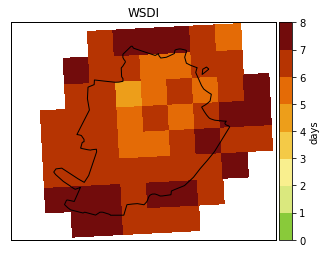

In [37]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/wsdi_era5-2km-italy_year_comune_torino_1991-2020.nc')

Wsdi = ds['WSDI']
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Wsdi),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Wsdi
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('WSDI')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/wsdi_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Discomfort Index

## It is a physiological thermal stress indicator for people based on dry-bulb and wet-bulb temperature.


In [103]:
##DATA
#Loading data: Max. temperature, humidity and pressure 
data_temp = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M'].values
data_umidità_s = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/QV_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
q=data_umidità_s['QV_2M']
data_press=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/PMSL_1991_2020_VHR-REA_IT_comune_torino.nc')
p=data_press['PMSL']

In [104]:
#Components for the evaluation of the index
T0 = 273.15
w = q #the mixing ratio can be approximated with the specific humidity

es = 611.0 * np.exp((17.67*(tasmax - T0)) / (tasmax - 29.65))

w_s =0.622*(es / p)
rh = np.round((w / w_s) * 100)

rh = xr.where(rh > 100, 100, rh)
rh.attrs["units"] = "%"

In [105]:
##Evaluation
tasmax_deg=tasmax-273.15
THI=tasmax_deg-(0.55 - 0.0055*rh) *(tasmax_deg-14.5)    #THI = Ta - (0.55 - 0.0055 * UR) (Ta - 14.5). Since it is not always possible to know the wet bulb temperature, the formula of the Thermohygrometric Index (THI) can be used
condition= (THI>=29) & (THI<32) #Threshold indicating dangerous conditions
classe=xr.where(condition,1,0)
classe_media=classe.resample(time='1Y').sum(dim='time')
classe_media1=classe_media.mean(dim='time')
classe_media2=classe_media1.to_dataset(name='Di')
Di_index=classe_media2.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/Di_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [70]:
#CSV
ds=classe_media.to_dataset(name='Di[days]')
Di_mean=ds.mean(dim= ['rlat','rlon']) 
Di_std=ds.std(dim= ['rlat','rlon'])
df=Di_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']) 
df_std=Di_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'Di[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Di[days]'] = np.round(df['Di[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/Di_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [71]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Thi_mean= classe_media.mean(dim='time')
clip_var = msk_me * Thi_mean
ds=clip_var.to_dataset(name='Di[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Di[d]'] = np.round(df['Di[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/discomfort_index/Di_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

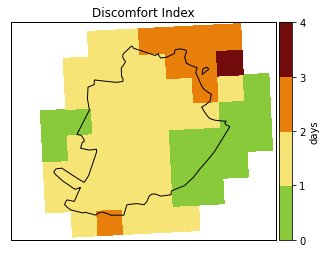

In [106]:
#Map
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/THI_index.nc')

THI = classe_media1
lon = classe_media1.lon.values
lat = classe_media1.lat.values

vmax =  round(np.nanmax(THI),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1,1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * THI
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('Discomfort Index')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/Di_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Apparent Temperature

## It represents the temperature perceived by human beings, resulting from the combined effect of air temperature, relative humidity.

In [159]:
##DATA
#Loading data: Temperature and Dew point temperature 
data_temp=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M']
data_tempdp=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TD_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tdps=data_tempdp['TD_2M']

In [160]:
#Evaluation
temp_deg=t-273.15
temp_deg["units"] = "°C"
tdps_deg=tdps-273.15
tdps_deg.attrs["units"] = "°C"
TApp= -2.653 + 0.994 * temp_deg + 0.0153 * (tdps_deg)**2;  #Tapp = −2.653 + 0.994 × Ta + 0 0153 × Td2

In [161]:
#Evaluation
condition= (TApp>=32) & (TApp<40)  #Threshold indicating conditions of extreme caution
classe=xr.where(condition,1,0)
classe_new=classe.resample(time='1Y').sum(dim='time')
classe_media=classe_new.mean(dim='time')
classe_media1=classe_media.to_dataset(name='TApp')
Apparent_Temperature=classe_media1.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [94]:
#CSV
ds=classe_new.to_dataset(name='TApp[days]')
TApp_mean=ds.mean(dim= ['rlat','rlon']) 
TApp_std=ds.std(dim= ['rlat','rlon'])
df=TApp_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'units'])
df_std=TApp_std.to_dataframe().reset_index().drop(columns=['height_2m','units']).rename(columns= {'TApp[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['TApp[days]'] = np.round(df['TApp[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [75]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

TApp_mean= classe_new.mean(dim='time')
clip_var = msk_me * TApp_mean
ds=clip_var.to_dataset(name='TApp[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'units']).dropna().reset_index(drop=True)
df['TApp[d]'] = np.round(df['TApp[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/Apparent _temperature/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

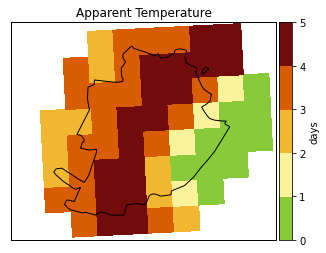

In [51]:
#Map
AT = classe_media 
lon = classe_media.lon.values
lat = classe_media.lat.values

vmax = round(np.nanmax(AT),0)  
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1,1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * AT
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('Apparent Temperature')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm days

## Number of days with daily maximum temperature greater than the 90th percentile of daily maximum temperature

In [129]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc') 
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "°K"
tasmax_per=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/90perc_tmax_2m_torino.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "°K"

In [130]:
##Evaluation
#Evaluation of the indicator through the xclim library
Warm_days=xc.tx90p(tasmax,tasmax_per, freq='YS', bootstrap=False)
Warm_days_mean=Warm_days.mean(dim='time')
Warm_days_mean=Warm_days_mean.to_dataset(name='Wd')
Warm_days=Warm_days_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/warm_days_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [132]:
#CSV
ds=Warm_days.to_dataset(name='Wd[days]')
tx90p_mean=ds.mean(dim= ['rlat','rlon']) 
tx90p_std=ds.std(dim= ['rlat','rlon'])
df=tx90p_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'quantile'])
df_std=tx90p_std.to_dataframe().reset_index().drop(columns=['height_2m','quantile']).rename(columns= {'Wd[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Wd[days]'] = np.round(df['Wd[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/warm_days_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [82]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Warm_days_mean=Warm_days.mean(dim='time')
clip_var = msk_me * Warm_days_mean
ds=clip_var.to_dataset(name='Wd[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'quantile']).dropna().reset_index(drop=True)
df['Wd[d]'] = np.round(df['Wd[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/Warm_days/warm_days_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

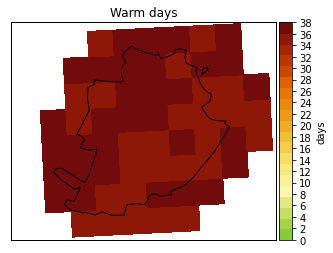

In [115]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/warm_days_era5-2km-italy_year_comune_torino_1991-2020.nc')

Wd = np.round((ds['Wd']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Wd),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,2),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 2),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Wd
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Warm days')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/warm_days_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm Wet Days

## Number of days with daily mean temperature greater than 75th percentile* of daily mean temperature and with daily precipitation greater than 75th percentile** of daily precipitation.

In [141]:
##DATA temp
#Loading data: temperature and 75th percentile of temperature
data_temp = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tas=data_temp['T_2M']
tas.attrs["units"] = "K"
tas_per=percentile_doy(tas, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [142]:
##DATA Prec
#Loading data: precipitation and 75th percentile of precipitation
data_prec = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TOT_PREC_1991_2020_VHR-REA_IT_comune_torino.nc')
pr=data_prec['TOT_PREC']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=75).sel(percentiles=75)
pr_per.attrs["units"] = "mm/day"

In [143]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas)
thresh = resample_doy(tas_per, tas)
tg75 = tas >= thresh
tg75=tg75.values

In [144]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh = resample_doy(pr_per, pr)
pr75 = pr >= thresh

In [145]:
#Evaluation
WW= (tg75==True) & (pr75==True)
classe_media1= xr.where(WW,1,0)
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WW')
warm_and_wet=classe_media3.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/ww_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [103]:
#CSV
ds=classe_media2.to_dataset(name='WW[days]')
Ww_mean=ds.mean(dim= ['rlat','rlon']) 
Ww_std=ds.std(dim= ['rlat','rlon'])
df=Ww_mean.to_dataframe().reset_index().drop(columns=[ 'percentiles'])
df_std=Ww_std.to_dataframe().reset_index().drop(columns=['percentiles']).rename(columns= {'WW[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WW[days]'] = np.round(df['WW[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/ww_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Ww_mean= classe_media2.mean(dim='time')
clip_var = msk_me * Ww_mean
ds=clip_var.to_dataset(name='WW[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'percentiles']).dropna().reset_index(drop=True)
df['WW[d]'] = np.round(df['WW[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/Warm_wet_days/ww_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

Text(0.5, 1.0, 'Warm Wet days')

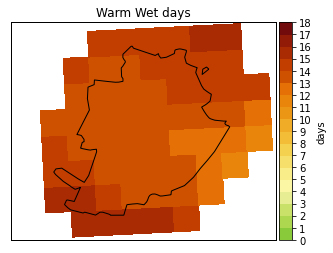

In [290]:
#Map 
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/Warm_and_wet.nc')

WW = classe_media3 
lon = classe_media3.lon.values   
lat = classe_media3.lat.values   

vmax = round(np.nanmax(WW),0)  
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * WW
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Warm Wet days')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/ww_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm Dry Days

## Number of days with daily mean temperature greater than 75th percentile** of daily mean temperature and with daily precipitation less than 25th percentile** of daily precipitation.

In [147]:
##DATA Temp
#Loading data: temperature and 75th percentile of temperature
data_temp = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tas=data_temp['T_2M']
tas.attrs["units"] = "K"
tas_per=percentile_doy(tas, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [148]:
##DATA Prec
#Loading data: precipitation and 25th percentile of precipitation
data_prec = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TOT_PREC_1991_2020_VHR-REA_IT_comune_torino.nc')
pr=data_prec['TOT_PREC']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=25).sel(percentiles=25)
pr_per.attrs["units"] = "mm/day"

In [149]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas)
thresh = resample_doy(tas_per, tas)
tg75 = tas >= thresh
#tg75=tg75

In [150]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh1 = resample_doy(pr_per, pr)
pr25 = pr <= thresh1
pr25=pr25.values

In [151]:
#Evaluation
WD= (tg75==True) & (pr25==True)
classe_media1= xr.where(WD,1,0)
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WD')
warm_and_wet=classe_media3.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/wd_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [109]:
#CSV
ds=classe_media2.to_dataset(name='WD[days]')
Wd_mean=ds.mean(dim= ['rlat','rlon']) 
Wd_std=ds.std(dim= ['rlat','rlon'])
df=Wd_mean.to_dataframe().reset_index().drop(columns=[ 'percentiles', 'height_2m'])
df_std=Wd_std.to_dataframe().reset_index().drop(columns=['percentiles']).rename(columns= {'WD[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WD[days]'] = np.round(df['WD[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/wd_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [152]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Wd_mean= classe_media2.mean(dim='time')
clip_var = msk_me * Wd_mean
ds=clip_var.to_dataset(name='WD[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'percentiles', 'height_2m']).dropna().reset_index(drop=True)
df['WD[d]'] = np.round(df['WD[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/Warm_dry_days/wd_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

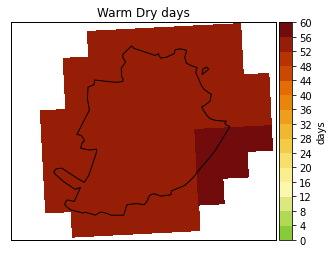

In [268]:
#Map
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/Warm_and_wet.nc')

WD = classe_media3 
lon = classe_media3.lon.values   
lat = classe_media3.lat.values   

vmax = round(np.nanmax(WD),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+4,4),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+4, 4),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * WD
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+3)
cbar.set_label('days')
plt.title('Warm Dry days')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/wd_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

### Consecutive Wet Days

## Largest number of consecutive days with daily precipitation greater than or equal to 1 mm.

In [156]:
##DATA Prec
#Loading data: Precipitation
data_prec = xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/TOT_PREC_1991_2020_VHR-REA_IT_comune_torino.nc')
pr=data_prec['TOT_PREC']
pr.attrs["units"] = "mm/day"

In [157]:
#Evaluation
#Evaluation of the indicator through the xclim library
Cwd=xc.maximum_consecutive_wet_days(pr, thresh='1 mm/day', freq='YS')
Cwd_mean=Cwd.mean(dim='time')
Cwd_mean=Cwd_mean.to_dataset(name='Cwd')
Cwd=Cwd_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/cwd_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [112]:
#CSV
Cwd_mean=Cwd.mean(dim= ['rlat','rlon']) 
Cwd_std=Cwd.std(dim= ['rlat','rlon'])
df=Cwd_mean.to_dataframe().rename(columns= {'TOT_PREC':'Cwd[days]'})
df_std=Cwd_std.to_dataframe().rename(columns= {'TOT_PREC':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Cwd[days]'] = np.round(df['Cwd[days]'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/cwd_era5-2km-italy_year_comune_torino_1991-2020.csv')

In [158]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Cwd_mean= Cwd.mean(dim='time')
clip_var = msk_me * Cwd_mean
ds=clip_var.to_dataset(name='Cwd[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat']).dropna().reset_index(drop=True)
df['Cwd[d]'] = np.round(df['Cwd[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/Consecutive_wet_days/cwd_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

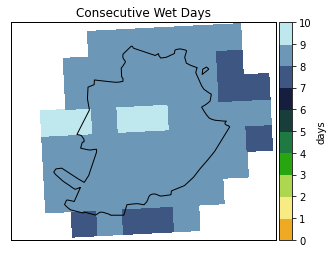

In [86]:
#Map
ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/cwd_era5-2km-italy_year_comune_torino_1991-2020.nc')

Cwd =  np.round((ds['Cwd']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Cwd),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0, 0.8, len(ticks)-1))

rev= list(reversed(colors))
cmap = plc.ListedColormap(rev)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Cwd
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Consecutive Wet Days')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/cwd_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Mean Temperature

## Mean of daily mean temperature.

In [162]:
##DATA
#Loading data: Temperature
data_temp=xr.open_dataset('/work/remhi/ap21322/SDG/box_2km/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M']
Tg=t-273.15

In [163]:
#Evaluation
Tg = Tg.resample(time = '1Y').mean(dim='time')
Tg_mean=Tg.mean(dim='time')
Tg_mean=Tg_mean.to_dataset(name='Tg')
Tg=Tg_mean.to_netcdf('/work/remhi/ap21322/SDG/netcdf_indicator/mean_temperature_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [140]:
#CSV
Tg_mean=Tg.mean(dim= ['rlat','rlon']) 
Tg_std=Tg.std(dim= ['rlat','rlon'])
df=Tg_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'T_2M':'Tg[°C]'})
df_std=Tg_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'T_2M':'Std[°C]'})
df['Std[°C]'] =(df_std['Std[°C]'])
#df['T_2M'] = np.round(df['T_2M'],0)
df.to_csv('/work/remhi/ap21322/SDG/csv/mean_temperature_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [164]:
#ShapeFile
mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Tg_mean= Tg.mean(dim='time')
clip_var = msk_me * Tg_mean
ds=clip_var.to_dataset(name='Tg[°C]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file('/work/remhi/ap21322/SDG/shape/mean_temperature/mean_temperature_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

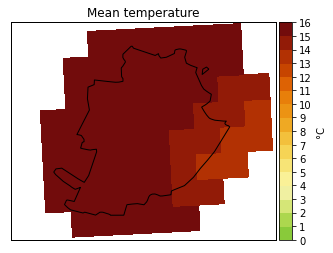

In [92]:
#Map
Tg = Tg_mean
lon = Tg_mean.lon.values   
lat = Tg_mean.lat.values   

vmax = round(np.nanmax(Tg),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset('/work/remhi/ap21322/SDG/sh_mask_To/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Tg
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile('/work/remhi/ap21322/SDG/sh_mask_To/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('°C')
plt.title('Mean temperature')
plt.savefig('/work/remhi/ap21322/SDG/mappe_indicatori/mean_temperature_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)